# Deep Learning Modeling

In [2]:
!pip install git+https://github.com/heartfelt-tech/BayesianOptimization.git

  Cloning https://github.com/heartfelt-tech/BayesianOptimization.git to /tmp/pip-req-build-0vvsgtw3
  Stored in directory: /tmp/pip-ephem-wheel-cache-mn2tcdw7/wheels/da/f8/4f/4041ecc1dd990ce1046eac683a3667a212b73f69c58840b38a
Successfully built bayesian-optimization


In [3]:
from sklearn.metrics import confusion_matrix, precision_score
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout,Activation,BatchNormalization,RepeatVector,GaussianDropout,ActivityRegularization
from keras.models import Sequential
from keras.regularizers import l2,l1
import keras.losses as losses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
# fix rng seed
seed = 42
np.random.seed(seed)

Using TensorFlow backend.


In [4]:
df = pd.read_pickle("../data/production/imputed_dataset.pickle")
x = df.drop("USDA Model", axis="columns").values
y = df["USDA Model"].values

# encode response as 1/0
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

x_train, x_test, y_train, y_test = train_test_split(x,encoded_Y, test_size=0.1, random_state=seed)

In [5]:
class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print('')
    print('.', end='')

In [6]:
def confusion(expected,predicted):
    exp_series = pd.Series(expected)
    pred_series = pd.Series(predicted)
    return pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

In [7]:
def train_model(model, optimizer='adam', use_train_test=True, batch_size=100, epochs=50, dot=True, verbose=0, ratio=.15):
    if dot:
        callbacks = []
    else:
        callbacks = [PrintDot()]
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    if use_train_test:
        model_output = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=[x_test,y_test],callbacks=callbacks)
    else:
        model_output = model.fit(x,encoded_Y,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_split=ratio,callbacks=callbacks)
        
    return model_output

In [8]:
def plot_model(model_output):
    #scores
    print('Training Accuracy : ' , np.mean(model_output.history["acc"]))
    print('Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))
    
    # Plot training & validation accuracy values
    plt.plot(model_output.history['acc'])
    plt.plot(model_output.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(model_output.history['loss'])
    plt.plot(model_output.history['val_loss'])
    plt.title('model_output loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [9]:
def model_confusion(model):
    y_pred = model.predict(x_test)
    rounded = [round(x[0]) for x in y_pred]
    y_pred1 = np.array(rounded,dtype='int64')
    
    print("Precision Score: {}".format(precision_score(y_test,y_pred1)))
    return confusion(y_test,y_pred1)

## Single-Layer Model

In [10]:
slm = Sequential()
slm.add(Dense(168, input_dim=112, activation='relu'))
slm.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
slm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
slm_res = slm.fit(x_train,y_train,epochs=100,batch_size=100,verbose=0,validation_data=[x_test,y_test],callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

..................................................
..................................................

Training Accuracy :  0.8209910533487904
Validation Accuracy :  0.8167202532099759


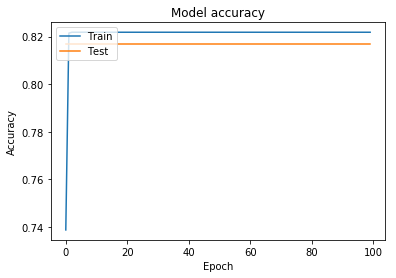

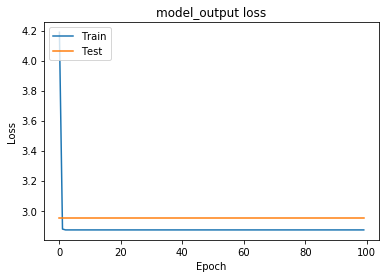

In [12]:
plot_model(slm_res)

In [13]:
model_confusion(slm)

Precision Score: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,All
Actual,,
0,254,254
1,57,57
All,311,311


> The model has very low precision, simply selecting 0 for every case

## Normalized Single-Layer
Normalizing the input should help the precision

In [14]:
nslm = Sequential()
nslm.add(BatchNormalization())
nslm.add(Dense(168, input_dim=112, activation='relu'))
nslm.add(Dense(1, activation='sigmoid'))

In [15]:
nslm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
nslm_res = nslm.fit(x_train,y_train,epochs=100,batch_size=100,verbose=0,validation_data=[x_test,y_test],callbacks=[PrintDot()])


..................................................
..................................................

Training Accuracy :  0.9535062653391434
Validation Accuracy :  0.8159163944360911


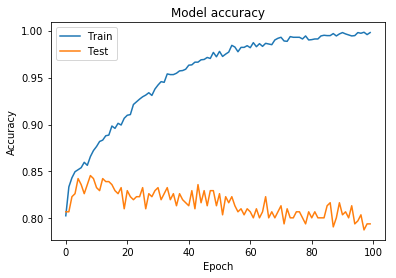

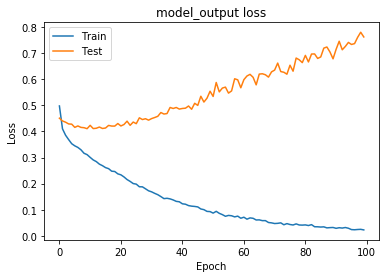

In [16]:
plot_model(nslm_res)

In [17]:
model_confusion(nslm)

Precision Score: 0.42857142857142855


Predicted,0,1,All
Actual,,,
0,226,28,254
1,36,21,57
All,262,49,311


> With normalization, the model is significantly better than always 0

## Two Layers with Normalization

In [18]:
tlm = Sequential()
tlm.add(BatchNormalization())
tlm.add(Dense(168, input_dim=112, activation='relu'))
tlm.add(Dense(64, activation='relu'))
tlm.add(Dense(1, activation='sigmoid'))

In [19]:
tlm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
tlm_res = tlm.fit(x_train,y_train,epochs=100,batch_size=100,verbose=0,validation_data=[x_test,y_test],callbacks=[PrintDot()])


..................................................
..................................................

Training Accuracy :  0.972962436490494
Validation Accuracy :  0.808553053926425


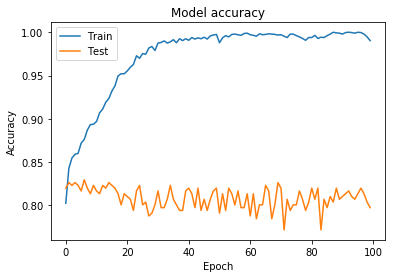

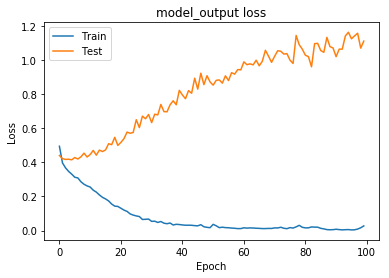

In [20]:
plot_model(tlm_res)

In [21]:
model_confusion(tlm)

Precision Score: 0.45161290322580644


Predicted,0,1,All
Actual,,,
0,220,34,254
1,29,28,57
All,249,62,311


> There is some obvious overfitting that is occurring. However, the recall precision is less skewed.

## Two-Layers with Normalization and Dropout
Adding a dropout layer will help protect against overfitting

In [22]:
dlm = Sequential()
dlm.add(BatchNormalization())
dlm.add(Dense(168, input_dim=112, activation='relu'))
dlm.add(Dense(64, activation='relu'))
dlm.add(Dropout(0.1))
dlm.add(Dense(1, activation='sigmoid'))

In [23]:
dlm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
dlm_res = dlm.fit(x_train,y_train,epochs=100,batch_size=100,verbose=0,validation_data=[x_test,y_test],callbacks=[PrintDot()])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

..................................................
..................................................

Training Accuracy :  0.9690661944803485
Validation Accuracy :  0.805530544843321


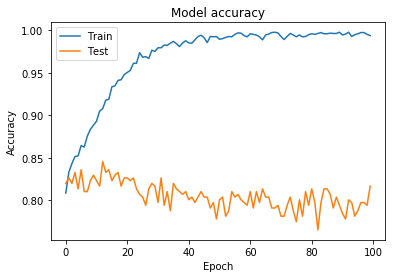

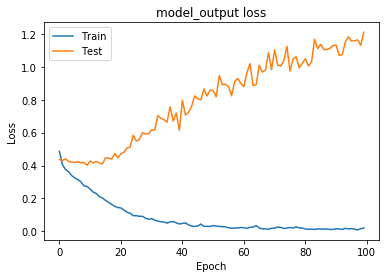

In [24]:
plot_model(dlm_res)

In [25]:
model_confusion(dlm)

Precision Score: 0.5


Predicted,0,1,All
Actual,,,
0,233,21,254
1,36,21,57
All,269,42,311


## Hyperparameter Optimization (Dropout and Learning Rate)

In [26]:
from keras.optimizers import Adam, Nadam
from bayes_opt import BayesianOptimization

In [27]:
def get_model(dropout_rate = 0.1):
    # create model
    dlm = Sequential()
    dlm.add(BatchNormalization())
    dlm.add(Dense(168, input_dim=112, activation='relu'))
    dlm.add(Dense(64, activation='relu'))
    dlm.add(Dropout(dropout_rate))
    dlm.add(Dense(1, activation='sigmoid'))
    return dlm

In [28]:
def fit_with(verbose, dropout_rate, lr):

    # Create the model using a specified hyperparameters.
    model = get_model(dropout_rate)

    # Train the model for a specified number of epochs.
    optimizer = Adam(lr=lr)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model with the train dataset.
    model.fit(x_train, y_train, epochs=10,
              batch_size=100, verbose=verbose)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(x=x_test,y=y_test, steps=10, verbose=0)
#     print('Test loss:', score[0])
#     print('Test accuracy:', score[1])

    # Return the accuracy.

    return score[1]

In [29]:
from functools import partial
verbose = 0
fit_with_partial = partial(fit_with, verbose)

In [30]:
# Bounded region of parameter space
pbounds = {'dropout_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=seed,
)

In [31]:
optimizer.maximize(init_points=10, n_iter=10,)
print(optimizer.max)

|   iter    |  target   | dropou... |    lr     |
-------------------------------------------------
|  1        |  0.8232   |  0.2498   |  0.009512 |
|  2        |  0.8199   |  0.3928   |  0.006027 |
|  3        |  0.8296   |  0.1624   |  0.001644 |
|  4        |  0.8039   |  0.1232   |  0.008675 |
|  5        |  0.8006   |  0.3404   |  0.00711  |
|  6        |  0.8328   |  0.1082   |  0.009702 |
|  7        |  0.8296   |  0.433    |  0.002202 |
|  8        |  0.8199   |  0.1727   |  0.001916 |
|  9        |  0.7974   |  0.2217   |  0.005295 |
|  10       |  0.8328   |  0.2728   |  0.002983 |
|  11       |  0.8264   |  0.5      |  0.01     |
|  12       |  0.8167   |  0.1      |  0.0001   |
|  13       |  0.8167   |  0.5      |  0.0001   |
|  14       |  0.8296   |  0.4659   |  0.01     |
|  15       |  0.8167   |  0.2968   |  0.01     |
|  16       |  0.8232   |  0.4234   |  0.01     |
|  17       |  0.8135   |  0.1      |  0.01     |
|  18       |  0.8296   |  0.3141   |  0.0001   |


## Hyperparameter Optimization 2 (Dimensions)

In [48]:
def get_model(dim):
    # create model
    dlm = Sequential()
    dlm.add(BatchNormalization())
    dlm.add(Dense(dim, activation='relu'))
    dlm.add(Dense(64, activation='relu'))
    dlm.add(Dropout(0.11))
    dlm.add(Dense(1, activation='sigmoid'))
    return dlm

In [49]:
def fit_with(verbose, dim):

    # Create the model using a specified hyperparameters.
    model = get_model(int(dim))

    # Train the model for a specified number of epochs.
    optimizer = Adam(lr=.01)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model with the train dataset.
    model.fit(x_train, y_train, epochs=10,
              batch_size=100, verbose=verbose)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(x=x_test,y=y_test, steps=10, verbose=0)
#     print('Test loss:', score[0])
#     print('Test accuracy:', score[1])

    # Return the accuracy.

    return score[1]

In [50]:
from functools import partial
verbose = 0
fit_with_partial = partial(fit_with, verbose)

In [51]:
# Bounded region of parameter space
pbounds = {'dim': (1, 2048)}
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    ptypes={'dim': int},
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=seed,
)

In [52]:
optimizer.maximize(init_points=10, n_iter=3,)

# for i, res in enumerate(optimizer.res):
#     print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |    dim    |
-------------------------------------
|  1        |  0.8199   |  1.127e+0 |
|  2        |  0.7846   |  1.46e+03 |
|  3        |  0.836    |  861.0    |
|  4        |  0.8232   |  1.295e+0 |
|  5        |  0.8521   |  1.131e+0 |
|  6        |  0.8264   |  1.096e+0 |
|  7        |  0.8071   |  1.725e+0 |
|  8        |  0.8039   |  1.045e+0 |
|  9        |  0.8328   |  1.639e+0 |
|  10       |  0.8071   |  122.0    |
|  11       |  0.8039   |  554.0    |
|  12       |  0.7781   |  2.048e+0 |
|  13       |  0.8296   |  338.0    |
{'target': 0.852090060710907, 'params': {'dim': 1131.0}}


In [53]:
optimizer.set_bounds(new_bounds={'dim':(800,1500)})
optimizer.maximize(
    init_points=0,
    n_iter=5,
)

|   iter    |  target   |    dim    |
-------------------------------------
|  14       |  0.8232   |  800.0    |
|  15       |  0.8296   |  1.218e+0 |
|  16       |  0.7942   |  1.379e+0 |
|  17       |  0.8103   |  946.0    |
|  18       |  0.8167   |  1.5e+03  |


In [54]:
def get_model(dim):
    # create model
    dlm = Sequential()
    dlm.add(BatchNormalization())
    dlm.add(Dense(1131, activation='relu'))
    dlm.add(Dense(dim, activation='relu'))
    dlm.add(Dropout(0.11))
    dlm.add(Dense(1, activation='sigmoid'))
    return dlm

In [55]:
def fit_with(verbose, dim):

    # Create the model using a specified hyperparameters.
    model = get_model(int(dim))

    # Train the model for a specified number of epochs.
    optimizer = Adam(lr=.01)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model with the train dataset.
    model.fit(x_train, y_train, epochs=10,
              batch_size=100, verbose=verbose)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(x=x_test,y=y_test, steps=10, verbose=0)
#     print('Test loss:', score[0])
#     print('Test accuracy:', score[1])

    # Return the accuracy.

    return score[1]

In [56]:
from functools import partial
verbose = 0
fit_with_partial = partial(fit_with, verbose)

In [57]:
# Bounded region of parameter space
pbounds = {'dim': (1, 2048)}
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    ptypes={'dim': int},
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=seed,
)

In [58]:
optimizer.maximize(init_points=10, n_iter=5,)

# for i, res in enumerate(optimizer.res):
#     print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |    dim    |
-------------------------------------
|  1        |  0.8167   |  1.127e+0 |
|  2        |  0.8167   |  1.46e+03 |
|  3        |  0.8167   |  861.0    |
|  4        |  0.8167   |  1.295e+0 |
|  5        |  0.8167   |  1.131e+0 |
|  6        |  0.8167   |  1.096e+0 |
|  7        |  0.8167   |  1.725e+0 |
|  8        |  0.8167   |  1.045e+0 |
|  9        |  0.8167   |  1.639e+0 |
|  10       |  0.7781   |  122.0    |
|  11       |  0.8167   |  2.047e+0 |
|  12       |  0.8167   |  2.047e+0 |
|  13       |  0.8167   |  2.048e+0 |
|  14       |  0.8167   |  1.855e+0 |
|  15       |  0.8167   |  1.855e+0 |
{'target': 0.8167202472686768, 'params': {'dim': 1127.0}}


In [59]:
optimizer.set_bounds(new_bounds={'dim':(1,128)})
optimizer.maximize(
    init_points=0,
    n_iter=5,
)

|   iter    |  target   |    dim    |
-------------------------------------
|  16       |  0.8199   |  127.0    |
|  17       |  0.8167   |  128.0    |
|  18       |  0.8167   |  1.0      |
|  19       |  0.8167   |  48.0     |
|  20       |  0.8167   |  25.0     |


In [60]:
optimizer.set_bounds(new_bounds={'dim':(64,128)})
optimizer.maximize(
    init_points=0,
    n_iter=5,
)

|   iter    |  target   |    dim    |
-------------------------------------
|  21       |  0.8199   |  76.0     |
|  22       |  0.8328   |  64.0     |
|  23       |  0.8039   |  91.0     |
|  24       |  0.8039   |  84.0     |
|  25       |  0.8328   |  69.0     |


## Optimized Hyperparameters

In [61]:
dlm = Sequential()
dlm.add(BatchNormalization())
dlm.add(Dense(1131, input_dim=112, activation='relu'))
dlm.add(Dense(64, activation='relu'))
dlm.add(Dropout(0.11))
dlm.add(Dense(1, activation='sigmoid'))

In [62]:
dlm.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
dlm_res = dlm.fit(x_train,y_train,epochs=100,batch_size=100,verbose=0,validation_data=[x_test,y_test],callbacks=[PrintDot()])


..................................................
..................................................

Training Accuracy :  0.9526905245655124
Validation Accuracy :  0.8016398692591015


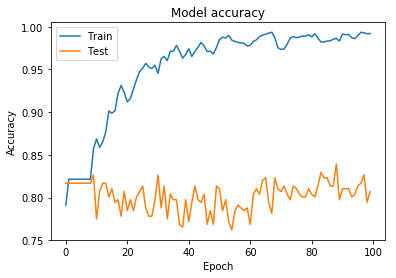

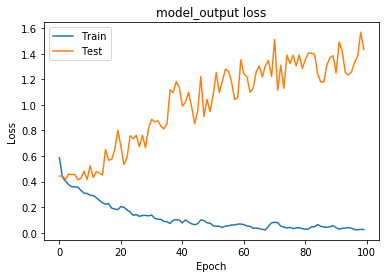

In [63]:
plot_model(dlm_res)

In [64]:
model_confusion(dlm)

Precision Score: 0.46808510638297873


Predicted,0,1,All
Actual,,,
0,229,25,254
1,35,22,57
All,264,47,311


## Optimizer Selection

In [65]:
def get_rlm():
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(1131, input_dim=112, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.11))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [66]:
adamax = get_rlm()
adamax_res = train_model(adamax, use_train_test=False, optimizer='adamax')
model_confusion(adamax)

Precision Score: 0.8813559322033898


Predicted,0,1,All
Actual,,,
0,247,7,254
1,5,52,57
All,252,59,311


In [67]:
nadam = get_rlm()
nadam_res = train_model(nadam, use_train_test=False, optimizer='nadam')
model_confusion(nadam)

Precision Score: 0.9444444444444444


Predicted,0,1,All
Actual,,,
0,251,3,254
1,6,51,57
All,257,54,311


In [68]:
sgd = get_rlm()
sgd_res = train_model(sgd, use_train_test=False, optimizer='sgd')
model_confusion(sgd)

Precision Score: 0.7241379310344828


Predicted,0,1,All
Actual,,,
0,246,8,254
1,36,21,57
All,282,29,311


In [69]:
nadam.save("../models/nadam.h5")
adamax.save("../models/adamax.h5")